# Stellar population models

H Spectral Energy Distribution (SED) ενός γαλαξία είναι η ολοκληρωμένη ένταση φωτός του γαλαξία στα φίλτρα φωτομετρίας broad band στα οποία έχει παρατηρηθεί. Η προσαρμογή καμπύλης στην SED λέγεται SED fitting και αποτελεί έναν κλάδο έρευνας με στόχο την ερμηνεία της SED και την εκτίμηση/ περιορισμό ιδιοτήτων των αστρικών πληθυσμών (ή άλλων παραγόντων) που αποτελούν τον γαλαξία.

Μια πρώτη απόπειρα προσδιορισμού των ιδιοτήτων γαλαξιών είναι το "Mass-to-Light Ratio" (Faber & Jackson 1976) με το οποίο εκτιμούμε την συνολική αστρική μάζα ενός γαλαξία από την συνολική λαμπρότητά του σε ένα φωτομετρικό φίλτρο. Στην σύγχρονη αστροφυσική έχουμε μοντέλα σύνθεσης αστρικών πληθυσμών (Stellar Population Synthesis Models) που μας επιτρέπουν να δημιουργήσουμε τεχνητά φάσματα γαλαξιών με διάφορες τιμές παραμέτρων (π.χ. αστρικές μάζες, ρυθμό αστρογένεσης, ηλικίες, μεταλλικότητες, redshift). Τα μοντέλα αυτά παράγονται χρησιμοποιώντας έναν συνδυασμό θεωρητικών και εμπειρικών template, τις σχετικές αυθονίες διαφόρων τύπων αστέρων και την γνώση μας για το πώς εξελίσεται ένας αστρικός πληθυσμός με τον χρόνο.

Η βάση για την Stellar Population Synthesis είναι ο Single Stellar population (Απλός Αστρικός πληθυσμός, SSP).
Εδώ θα ανεβάσουμε διάφορα template απλών αστρικών πληθυσμών (με διαφορετικά χαρακτηριστικά το κάθε ένα) ακολουθώντας την "συνταγή" των [Bruzual & Charlot 2003](https://ui.adsabs.harvard.edu/abs/2003MNRAS.344.1000B/abstract) 

Η γενική νοοτροπία κατασκευής ενός απλού αστρικού πλυθησμού περιγράφεται με λεπτομέρεια από τον [Conroy 2013](https://ui.adsabs.harvard.edu/abs/2013ARA%26A..51..393C/abstract).

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pickle
import itertools
from astropy import units as  u
from astropy.cosmology import FlatLambdaCDM
from scipy import constants as cst
from scipy import integrate

# Functions

In [2]:

def Flambda_to_Fnu(flux_lambda, wl_angst): 
    
    """
    This function transforms flux F_\lambda to F_\nu
    input:
    -flux in units of (some luminosity units) / Angstrom
    -wavelength (spectral axis) in Angstrom
    output:
    -flux in units of (some luminosity units) / Hz
    """
    
    Angstrom = 1e10

    flux_nu = flux_lambda * (wl_angst**2. ) / (cst.c * Angstrom) 
    return flux_nu

def SolarLumi_to_ergs(intensity): 
    
    """
    This function transforms L_\odot to erg/s
    input:
    -flux in units of SolarLumi/(some spectral unit) or luminosity in units of SolarLumi
    output:
    -flux in units of erg/s/(some spectral unit) or luminosity in units of erg/s
    """
     
    return intenisty*(3.846e33)


def Calzetti(gal_nu, gal_Fnu,GAebv):

    """
    This function computes the effect of reddening in the galaxy template (Calzetti law)
    input:
    - frequencies in Hz
    - Fluxes in Fnu
    - the reddening value E(B-V)_gal
    output:
    - frequencies in Hz
    - Fluxes in Fnu Reddened 
    """
    RV = 4.05 #obscuration at V       

    gal_lambda_m = cst.c / gal_nu * 1e6   #spectral axis: from Hz ----> microns 
    wl = gal_lambda_m[::-1]       #invert for lambda (ascending order of wavelength)
    k = np.zeros(len(wl))      #απορροφηση

    w0 = tuple([wl <= 0.12])  #lower limit for Calzetti law
    w1 = tuple([wl < 0.63])
    w2 = tuple([wl >= 0.63])

    x1 = np.argmin(np.abs(wl - 0.12))
    x2 = np.argmin(np.abs(wl - 0.125))
    
    #-----  equation 4 from Calzetti 2000 -----#

    k[w2] = 2.659 * (-1.857 + 1.040 /wl[w2])+RV
    k[w1] = 2.659 * (-2.156 + (1.509/wl[w1]) - (0.198/wl[w1]**2) + (0.011/wl[w1]**3))+RV
    if (wl[x1] - wl[x2]) != 0:  # avoid division by zero
        k[w0] = k[x1] + ((wl[w0] - 0.12) * (k[x1] - k[x2]) / (wl[x1] - wl[x2])) +RV
    else:
        k[w0] = 0
    
    #-----  equation 2 from Calzetti 2000 -----#

    gal_k= k[::-1] #invert for nus
    gal_Fnu_red = gal_Fnu * 10**(-0.4 * gal_k * GAebv)
    
    return gal_nu, gal_Fnu_red


def CharlotFall(gal_nu, gal_Fnu,GAebv):

    """
    This function computes the effect of reddening in the galaxy template (Charlot and Fall 2000)
    input:
    - frequencies in Hz
    - Fluxes in Fnu
    - the reddening value E(B-V)_gal
    output:
    - frequencies in Hz
    - Fluxes in Fnu Reddened
    """
    RV = 5.9        

    gal_lambda_m = cst.c / gal_nu * 1e6  #in microns 
    wl = gal_lambda_m[::-1]  #invert for lambda

    kcf = RV * (wl/5500)**(-0.7)

    gal_k= kcf[::-1] #invert for nus
    gal_Fnu_red = gal_Fnu* 10**(-0.4 * gal_k * GAebv)
    return gal_nu, gal_Fnu_red


# Load Templates

In [3]:
route_temps = 'templates/'

# ------------------ Stellar population -----------------#
BC03dict = pickle.load(open(route_temps + 'BC03_840seds.pickle', 'rb'), encoding='latin1')  

print("\n This template file is a dictionary with keys : \n", BC03dict.keys())  #it is a dictionary with thesekeys

print("\n We have " , len(BC03dict['age-values']), "different ages of SSPs.")
print("\n We have " , len(BC03dict['tau-values']), "different e-folding times for SFR.")

print("\n These templates correspond to a single value of metallicity, fixed to ", BC03dict['metallicity-values'], " solar metallicity.")




 This template file is a dictionary with keys : 
 dict_keys(['age-values', 'fesc', 'parameters', 'metallicity-values', 'SFR', 'dustextinct-values', 'SED', 'tau-values', 'wavelength', 'description'])

 We have  30 different ages of SSPs.

 We have  28 different e-folding times for SFR.

 These templates correspond to a single value of metallicity, fixed to  [1.]  solar metallicity.


# Exploring templates and building a grid step-by-step

### 01. The spectral axis

In [4]:
BC03dict['wavelength']

<Quantity [9.1e+01, 9.4e+01, 9.6e+01, ..., 1.2e+06, 1.4e+06, 1.6e+06] Angstrom>

Στο παραπάνω κελί βλέπουμε ότι στο key 'wavelength' του dictionary αυτού έχουμε μια λίστα από τιμές με μονάδες Angstrom.
Στο επόμενο κελί θα ορίσουμε μια array που θα ονομάσουμε wavelegths η οποία θα περιέχει τις τιμές αυτές (που ξέρουμε ότι είναι Angstrom).  Τα αντικείμενα np.array δεν έχουν μονάδες.

In [5]:
wavelengths = BC03dict['wavelength'].value  #in angstrom
print(np.shape(wavelengths))  

(1221,)


### 02. Ages of Simple Stellar Population

The intensity on the template dictionary is the following: 

In [6]:
BC03dict['SED']

<Quantity [[[[[[6.91353558e-04, 7.90678427e-04, 8.45444998e-04, ...,
                4.64735203e-11, 2.50250068e-11, 1.46366711e-11]]],


             [[[6.94191470e-04, 7.93878699e-04, 8.48873455e-04, ...,
                4.58335191e-11, 2.46800079e-11, 1.44346976e-11]]],


             [[[6.95109454e-04, 7.94913419e-04, 8.49982054e-04, ...,
                4.56208705e-11, 2.45653786e-11, 1.43675904e-11]]],


             ...,


             [[[6.96844229e-04, 7.96868098e-04, 8.52076447e-04, ...,
                4.52107568e-11, 2.43443060e-11, 1.42381691e-11]]],


             [[[6.96847329e-04, 7.96871590e-04, 8.52080189e-04, ...,
                4.52100137e-11, 2.43439054e-11, 1.42379346e-11]]],


             [[[6.96850119e-04, 7.96874734e-04, 8.52083557e-04, ...,
                4.52093449e-11, 2.43435449e-11, 1.42377236e-11]]]],



            [[[[5.47117305e-04, 6.25700861e-04, 6.69026731e-04, ...,
                5.87376359e-11, 3.16567048e-11, 1.85297403e-11]]],


            

In [7]:
print("The intensity is in units of solar luminosity per Angstrom, and it has a shape of",  
      np.shape(BC03dict['SED']))


The intensity is in units of solar luminosity per Angstrom, and it has a shape of (1, 30, 28, 1, 1, 1221)


The second index denotes the age differentiation (we have 30 different age values), the third denotes the tau differentiation (we have 28 different tau values), the last row is the intensity value.

Let's plot the template SEDs that correspond to different age (same population, evolved at different age).

In [8]:
# The age values are:
BC03dict['age-values']

<Quantity [1.00000000e+07, 1.26896100e+07, 1.61026203e+07, 2.04335972e+07,
           2.59294380e+07, 3.29034456e+07, 4.17531894e+07, 5.29831691e+07,
           6.72335754e+07, 8.53167852e+07, 1.08263673e+08, 1.37382380e+08,
           1.74332882e+08, 2.21221629e+08, 2.80721620e+08, 3.56224789e+08,
           4.52035366e+08, 5.73615251e+08, 7.27895384e+08, 9.23670857e+08,
           1.17210230e+09, 1.48735211e+09, 1.88739182e+09, 2.39502662e+09,
           3.03919538e+09, 3.85662042e+09, 4.89390092e+09, 6.21016942e+09,
           7.88046282e+09, 1.00000000e+10] yr>

In [9]:
Nage = len(BC03dict['age-values'])  #πληθος διαφορετικων ηλικιών (30)
print(Nage)

30


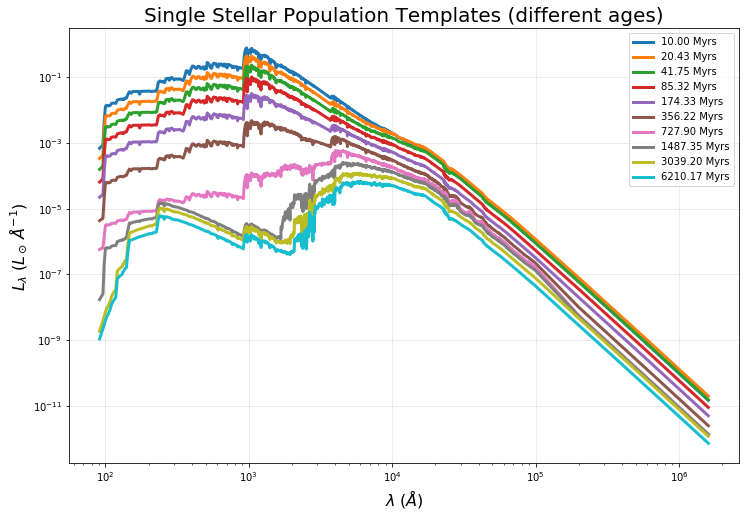

In [10]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)

for i in range(Nage)[::3]:   #we will show every 3rd age (instead of all 30 ages- for clearer visualisation)
    age = BC03dict['age-values'].value[i]/(1e6)
    SED = BC03dict['SED'][0,i,0,0,0,:].value
    ax1.plot(wavelengths,SED, lw = 3, label = "{:.2f} Myrs".format(age) )

ax1.set_ylabel(r"$  L_{\lambda} \;(L_\odot\,\AA^{-1})$ ", fontsize = 16)
ax1.set_xlabel(r"$\lambda \; (\AA)$", fontsize = 16)
ax1.grid(alpha = 0.3)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_title(r"Single Stellar Population Templates (different ages)", fontsize = 20)
ax1.legend(loc="upper right")
#plt.savefig('StellarTemps_ages.png', bbox_inches='tight')
plt.show()

### 0.3 e-folding time of Star Formation Rate for the population

In [11]:
# The tau values are:
BC03dict['tau-values']

<Quantity [ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
            1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,
            6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ] Gyr>

Let's plot the template SEDs that correspond to different tau (same population, at same age, but different star formation rate).

In [12]:
Ntau = len(BC03dict['tau-values'])  #πληθος διαφορετικων τ  (28)
print(Ntau)

28


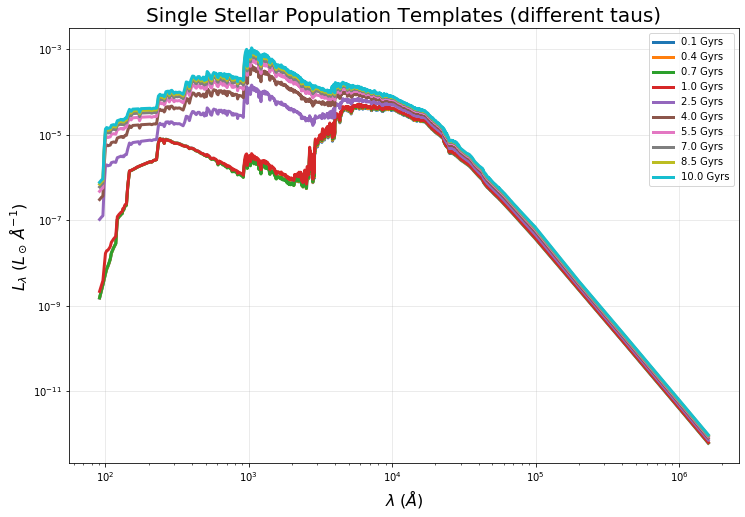

In [13]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)

for i in range(Ntau)[::3]:   #we will show every 3rd tau (instead of all 28 taus- for clearer visualisation)
    tau = BC03dict['tau-values'].value[i]
    SED = BC03dict['SED'][0,29,i,0,0,:].value
    ax1.plot(wavelengths,SED, lw = 3, label = "{} Gyrs".format(tau) )

ax1.set_ylabel(r"$  L_{\lambda} \;(L_\odot\,\AA^{-1})$ ", fontsize = 16)
ax1.set_xlabel(r"$\lambda \; (\AA)$", fontsize = 16)
ax1.grid(alpha = 0.3)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_title(r"Single Stellar Population Templates (different taus)", fontsize = 20)
ax1.legend(loc="upper right")
#plt.savefig('StellarTemps_taus.png', bbox_inches='tight')
plt.show()

### 0.4 Dust attenuation & Color excess 

Λεπτομερής περιγραφή για το πώς το αστρικό φως γίνεται attenuated από την σκόνη σε γαλαξίες βρίσκεται στους [Salim & Narayanan, 2020](https://ui.adsabs.harvard.edu/abs/2020ARA%26A..58..529S/abstract).\\    
Δύο πολύ διαδεδομένοι "attenuation law" που προσομοιάζουν με ημι-αναλυτικό τρόπο την απορρόφηση αστρικού φωτός λόγω σκόνης που παρατηρούμε σε αστρικά σμήνη στον Γαλαξία μας και στα νεφη του Μαγγελάνου είναι ο νόμος που περιγράφεται από την [Calzetti 2000](https://ui.adsabs.harvard.edu/abs/2000ApJ...533..682C/abstract) και ο νόμος που περιγράφεται από τους [Charlot & Fall, 2000](https://ui.adsabs.harvard.edu/abs/2000ApJ...539..718C/abstract).  \\          
Έχουμε ορίσει και τους δύο αυτούς νόμους σε συναρτήσεις (στην ενότητα Functions), για ευκολία.    

Στα παρακάτω θα χρησιμοποιήσουμε τον νόμο Calzetti 2000.

In [14]:
# Ορίζω μια array με τιμές B-V extinction από 0 μέχρι και 0.975 με βήμα 0.025

ebvgal_array = np.array(np.arange(0.,100.,2.5)/100)
ebvgal_array


array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
       0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
       0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
       0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
       0.9  , 0.925, 0.95 , 0.975])

In [15]:
Nage = len(BC03dict['age-values'])  #πληθος διαφορετικων ηλικιών (30)
print(Nage)
Ntau = len(BC03dict['tau-values'])  #πληθος διαφορετικων τ  (28)
print(Ntau)
Nebv = len(ebvgal_array)  #πληθος διαφορετικων E(B-V) (40 συνολικά)
print(Nebv)

idxs = [np.arange(Nage), np.arange(Ntau), np.arange(Nebv)]
idxs

30
28
40


[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39])]

In [16]:
#Make all possible combinations of these parametres (triplettes of age, tau and ebv index values)
par_idxs_combinations = np.array(list(itertools.product(*idxs)))
print(len(par_idxs_combinations))

33600


Στο επομενο βήμα θα φτιάχουμε μια λούπα η οποία για κάθε "τριπλέτα" age-tau-ebv:
- θα επιλέγει το template που αντιστοιχει στην εκάστοτε ηλικία και τ
- θα εφαρμόζει τον νόμο απορρόφησης από σκόνη που αντιστοιχεί την τιμή extinction της τριπλέτας και 
- συμπληρώνει ένα dictionary που για κάθε τριπλέτα αντιστοιχεί σε συχνοτητες Hz και ενταση σε erg/s/Hz


In [17]:
%%time

GALAXY_dict = dict()     # gia kathe mia apo tis tripletes 
GALAXY_SFRdict = dict()   #deutereuon/ dedomenou age kai tau sou dinei kat eutheian to SFR
GALAXY_ATTdict = dict()   #deutereuon/ dedomenis kathe tripletas sou dinei synoliki aporrofimeni lamprothta

for jj in par_idxs_combinations:
    agei=jj[0]
    taui=jj[1]
    ebvi=jj[2]
    
    gal_wl, gal_Fwl =  BC03dict['wavelength'],BC03dict['SED'][:,agei,taui,:,:,:].squeeze()
    gal_nus= gal_wl.to(u.Hz, equivalencies=u.spectral())[::-1] #invert
    gal_Fnu= Flambda_to_Fnu(gal_Fwl , gal_wl)[::-1]  # Fnu2Flambda
    gal_SFR= BC03dict['SFR'][:,agei,taui,:,:].squeeze()

    #applying reddening to the spectral values, and all 40 ebv values (from 0 to 0.975)
    gal_nu, gal_Fnu_red = Calzetti(gal_nus.value, gal_Fnu.value, ebvgal_array[ebvi])  

    GALAXY_dict[str(BC03dict['tau-values'].value[taui]),str(np.log10(BC03dict['age-values'].value[agei])), str(ebvgal_array[ebvi])] = gal_nu, gal_Fnu_red*1e18  
    GALAXY_SFRdict[str(BC03dict['tau-values'].value[taui]),str(np.log10(BC03dict['age-values'].value[agei]))] = gal_SFR 

    gal_Fnu_int = integrate.trapz(gal_Fnu.value, x=gal_nus.value)
    gal_Fnured_int = integrate.trapz(gal_Fnu_red, x=gal_nu)
    gal_att_int = gal_Fnu_int- gal_Fnured_int
    GALAXY_ATTdict[str(BC03dict['tau-values'].value[taui]),str(np.log10(BC03dict['age-values'].value[agei])), str(ebvgal_array[ebvi])] = gal_att_int 

# To 1e18 στην ένταση αφορά την κανονικοποίηση των templates σε μια ηλιακή μάζα   
# Sta dictionaries xrisimopoiisame logarithmo ilikias kai logarithmo syxnothtas

CPU times: user 19.3 s, sys: 369 ms, total: 19.6 s
Wall time: 19.6 s


In [18]:
print('There is a total of ', len(list(GALAXY_dict.keys())), 'different stellar templates')

There is a total of  33600 different stellar templates


Let's select 5 at random and plot them.

In [19]:
Number_of_temps_to_plot = 5
np.random.seed(42)    #for reproducibility purposes
TempSelect = np.random.choice(range(len(list(GALAXY_dict.keys()))), size=Number_of_temps_to_plot)

for i in range(Number_of_temps_to_plot):
    print(list(GALAXY_dict.keys())[TempSelect[i]])

('0.3', '8.448275862068966', '0.875')
('7.0', '7.0', '0.5')
('0.3', '8.03448275862069', '0.1')
('4.5', '7.517241379310345', '0.625')
('0.2', '8.551724137931034', '0.25')


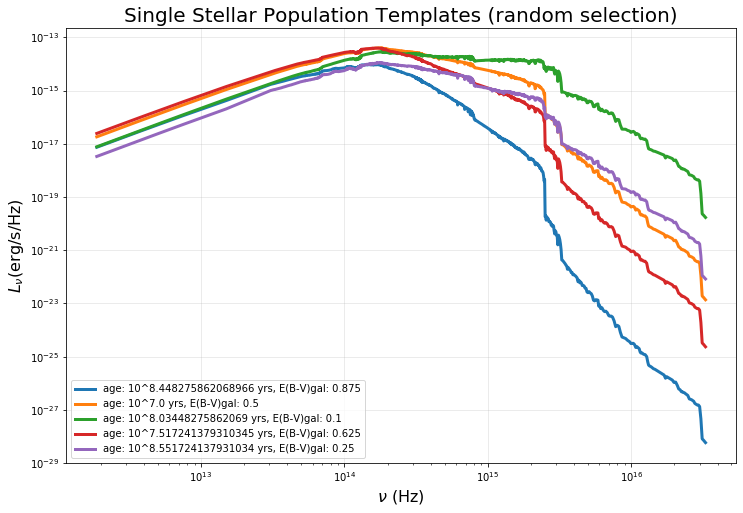

In [20]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)

for i in TempSelect:   
    nu = GALAXY_dict[list(GALAXY_dict.keys())[i]][0]
    F_nu = GALAXY_dict[list(GALAXY_dict.keys())[i]][1]
    age = list(GALAXY_dict.keys())[i][1]
    ebv = list(GALAXY_dict.keys())[i][2]
    ax1.plot(nu,F_nu, lw = 3, label = "age: 10^{} yrs, ".format(age)+"E(B-V)gal: {}".format(ebv) )

ax1.set_ylabel(r"$L_{\nu} $ (erg/s/Hz)", fontsize = 16)
ax1.set_xlabel(r"$\nu$ (Hz)", fontsize = 16)
ax1.grid(alpha = 0.3)
ax1.set_yscale('log')
ax1.set_ylim([1e-29, None])
ax1.set_xscale('log')
ax1.set_title(r"Single Stellar Population Templates (random selection)", fontsize = 20)
ax1.legend(loc="lower left")
#plt.savefig('StellarTemps_attenuated_random.png', bbox_inches='tight')
plt.show()